# Imports

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torcheval

# seaborn
import seaborn as sns
sns.set()
sns.set_style(style='white')

# Data

In [272]:
dataset = MNIST(root='data/', download=True, transform=transforms.ToTensor())

## Image sample

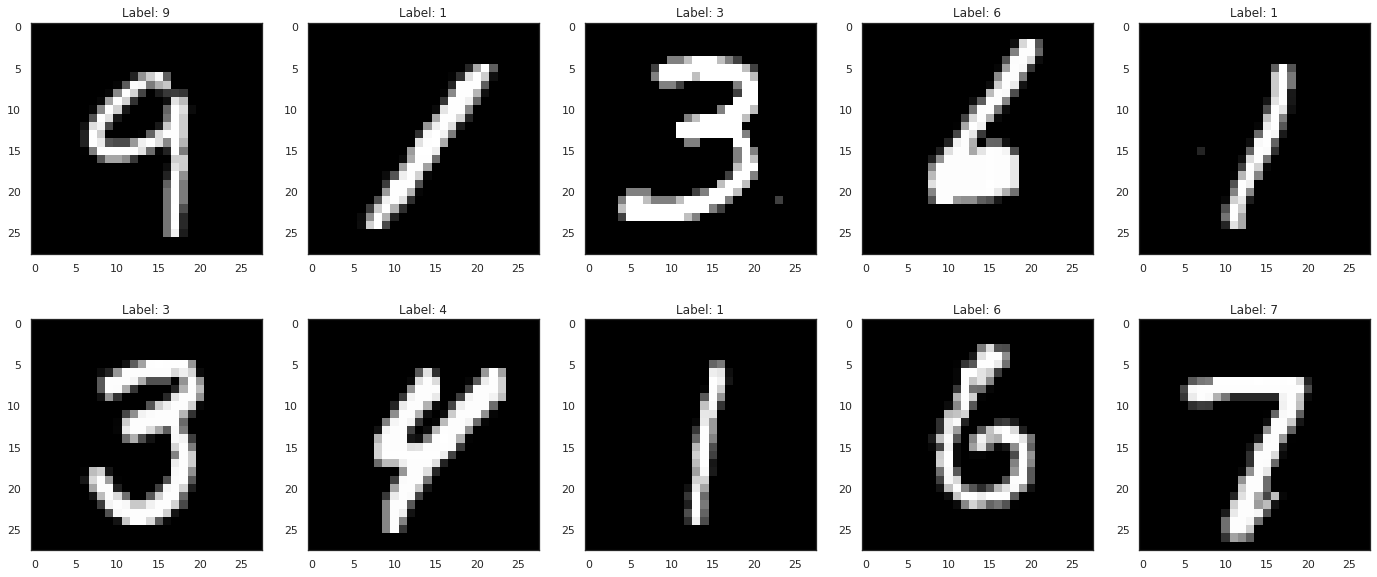

In [273]:
w = 5
h = 5
fig = plt.figure(figsize=(24, 10))
columns = 5
rows = 2

for i in range(1, columns*rows +1):
    idx = np.random.choice(len(dataset))
    image, label = dataset[idx]
    image = image[0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')
    plt.title('Label: {}'.format(label))
plt.show()

## Spliting Data

In [274]:
split_percentage = [0.7, 0.2, 0.1]
assert ((1 + 10 **-6) > np.sum(split_percentage) > (1 - 10**-6)), "Sum of precentage of train, validation, and test is not equal with 1."
n_train = int(len(dataset) * split_percentage[0])
n_val = int(len(dataset) * split_percentage[1])
n_test = len(dataset) - n_train - n_val

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

print("Spliting the MNIST dataset:")
print("Size train dataset:", n_train)
print("Size train dataset:", n_val)
print("Size train dataset:", n_test)

Spliting the MNIST dataset:
Size train dataset: 42000
Size train dataset: 12000
Size train dataset: 6000


# Model

In [315]:
class Logistic_Regression:
    def __init__(self, params) -> None:
        """
        inputs:
            params: 
                type: dictionary
                description: a dictionary including parameters of the neural network
                keys:
                    input_size = size of image
                    hidden_layer_size_arr = array of size of hidden layers
                    n_classes = number of classes
                    
        """

        self.params = params
        self.model = self.build_model()


    def build_model(self):
        hidden_arr_size = self.params['hidden_arr_size']
        input_size = self.params['input_size']
        n_classes = self.params['n_classes']
        
        model = nn.Sequential()

        if len(hidden_arr_size) == 0: # model with no hidden model
            model.append(nn.Linear(input_size, n_classes, dtype=torch.float32))
        else:
            model.append(nn.Linear(input_size, hidden_arr_size[0], dtype=torch.float32))
            model.append(nn.ReLU())
            for i in range(len(hidden_arr_size) - 1):
                model.append(nn.Linear(hidden_arr_size[i], hidden_arr_size[i+1], dtype=torch.float32))
                model.append(nn.ReLU())
            model.append(nn.Linear(hidden_arr_size[-1], n_classes, dtype=torch.float32))
        
        model.append(nn.Softmax(dim=1))

        return model


    def forward(self, xb):
        out = self.model(xb)
        return out


    def predict(self, xb):
        one_hot_vec = self.forward(xb)
        return torch.argmax(one_hot_vec, dim=1)


    def make_dataset_compatible(self, dataset):
        images = dataset.dataset.data
        images = images.type(torch.float32).reshape(-1, self.params['input_size'])
        targets = dataset.dataset.targets
        targets_one_hot = nn.functional.one_hot(targets, num_classes=self.params['n_classes']).type(torch.float32)
        return images, targets_one_hot


    def evaluate(self, dataset):
        images, targets_one_hot = self.make_dataset_compatible(dataset)
        with torch.no_grad():
            accuracy = torcheval.metrics.MulticlassAccuracy()
            CEloss = nn.CrossEntropyLoss()
            ys = self.forward(images)
            accuracy.update(torch.argmax(ys, dim=1), torch.argmax(targets_one_hot, dim=1))
            
            eval_dict = {
                'accuracy': float(accuracy.compute()),
                'loss': float(CEloss(ys, targets_one_hot))
            }

        return eval_dict


    def train_step(self, dataloader, optimizer):
        for xs, ts in dataloader:
            ys = self.forward(xs)
            CEloss = nn.CrossEntropyLoss()
            loss = CEloss(ys, ts)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 

        return loss.item()


    def fit(self, train_dataset, val_dataset, n_epochs, batch_size, lr, show_plot=False):
        train_images, train_targets_one_hot = self.make_dataset_compatible(train_dataset)
        train_ds = TensorDataset(train_images, train_targets_one_hot)
        train_dl = DataLoader(train_ds, batch_size, shuffle=True)

        opt = torch.optim.SGD(self.model.parameters(), lr=lr)

        history = []
        for e in range(n_epochs):
            #train-phase
            loss = self.train_step(train_dl, opt)          

            #validation-phase
            eval_dict = self.evaluate(val_dataset)

            result_dict = {
                'epoch': e+1,
                'loss': loss,
                'accuracy': eval_dict['accuracy'],
                'val_loss': eval_dict['loss']
            }

            history.append(result_dict)

            if (e + 1) % (n_epochs/10) == 0:
                print('Epoch [{:2}/{}] - Train Loss: {:.5f} - Accuracy: {:.5f} - Validation Loss: {:.5f}'.format(e+1, n_epochs, loss, eval_dict['accuracy'], eval_dict['loss']))

        # plot
        if show_plot:
            n_plot = len(history)
            epochs = []
            loss_arr = []
            accuracy_arr = []
            val_loss_arr = []

            for i in range(n_plot):
                epochs.append(history[i]['epoch'])
                loss_arr.append(history[i]['loss'])
                accuracy_arr.append(history[i]['accuracy'])
                val_loss_arr.append(history[i]['val_loss'])
            
            fig, axs = plt.subplots(1,2, figsize=(20,10))
            fig.suptitle('training process')

            axs[0].plot(epochs, loss_arr, "-b", label="Train Loss")
            axs[0].plot(epochs, val_loss_arr, "-r", label="Validation loss")
            axs[0].legend(loc="upper right")
            axs[1].plot(epochs, accuracy_arr)
            
            plt.show()

    def save_model_params(self, path):
        torch.save(self.model.state_dict(), path)


    def load_model_params(self, path):
        self.model.load_state_dict(torch.load(path))

# Training the Model

Epoch [10/100] - Train Loss: 1.60501 - Accuracy: 0.85642 - Validation Loss: 1.60656
Epoch [20/100] - Train Loss: 1.58222 - Accuracy: 0.86908 - Validation Loss: 1.59333
Epoch [30/100] - Train Loss: 1.55153 - Accuracy: 0.87438 - Validation Loss: 1.58753
Epoch [40/100] - Train Loss: 1.56729 - Accuracy: 0.87762 - Validation Loss: 1.58346
Epoch [50/100] - Train Loss: 1.47134 - Accuracy: 0.97837 - Validation Loss: 1.48559
Epoch [60/100] - Train Loss: 1.49914 - Accuracy: 0.98205 - Validation Loss: 1.48092
Epoch [70/100] - Train Loss: 1.51599 - Accuracy: 0.98362 - Validation Loss: 1.47889
Epoch [80/100] - Train Loss: 1.47137 - Accuracy: 0.98478 - Validation Loss: 1.47739
Epoch [90/100] - Train Loss: 1.48279 - Accuracy: 0.98570 - Validation Loss: 1.47646
Epoch [100/100] - Train Loss: 1.48160 - Accuracy: 0.98643 - Validation Loss: 1.47561


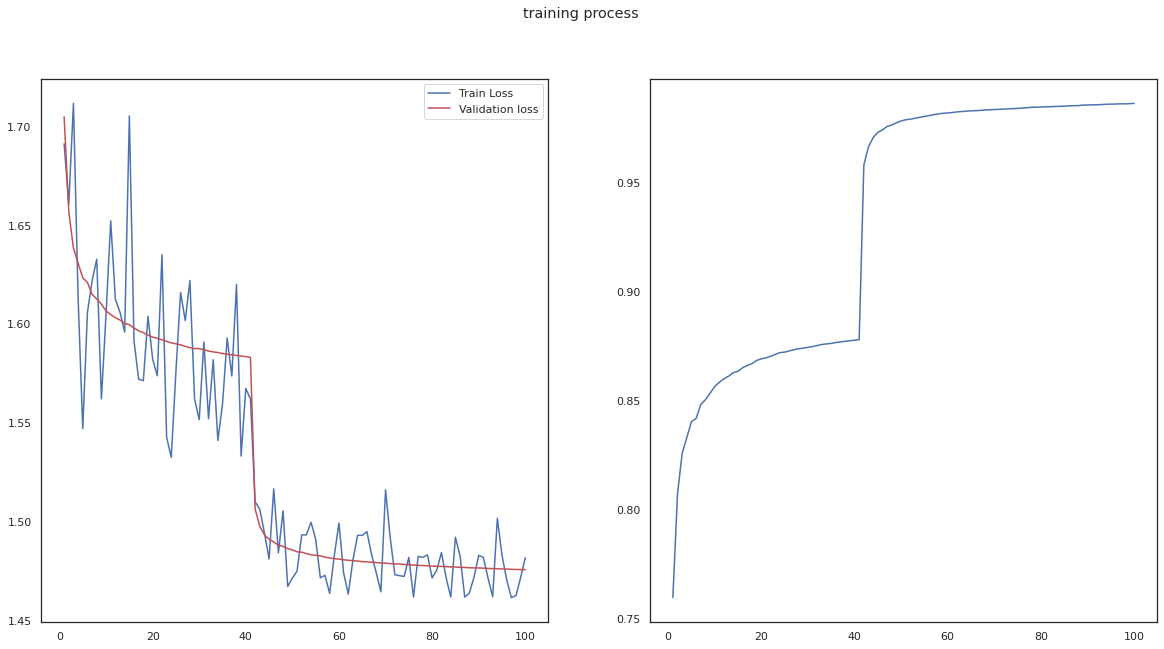

In [318]:
params = {
    'input_size': 28*28,
    'hidden_arr_size' : [256, 256],
    'n_classes': 10
}

LR = Logistic_Regression(params=params)

LR.fit(train_data, val_data, 100, 100, 0.001, True)


# Results

Accuracy: 0.9864333271980286
Loss: 1.4756057262420654


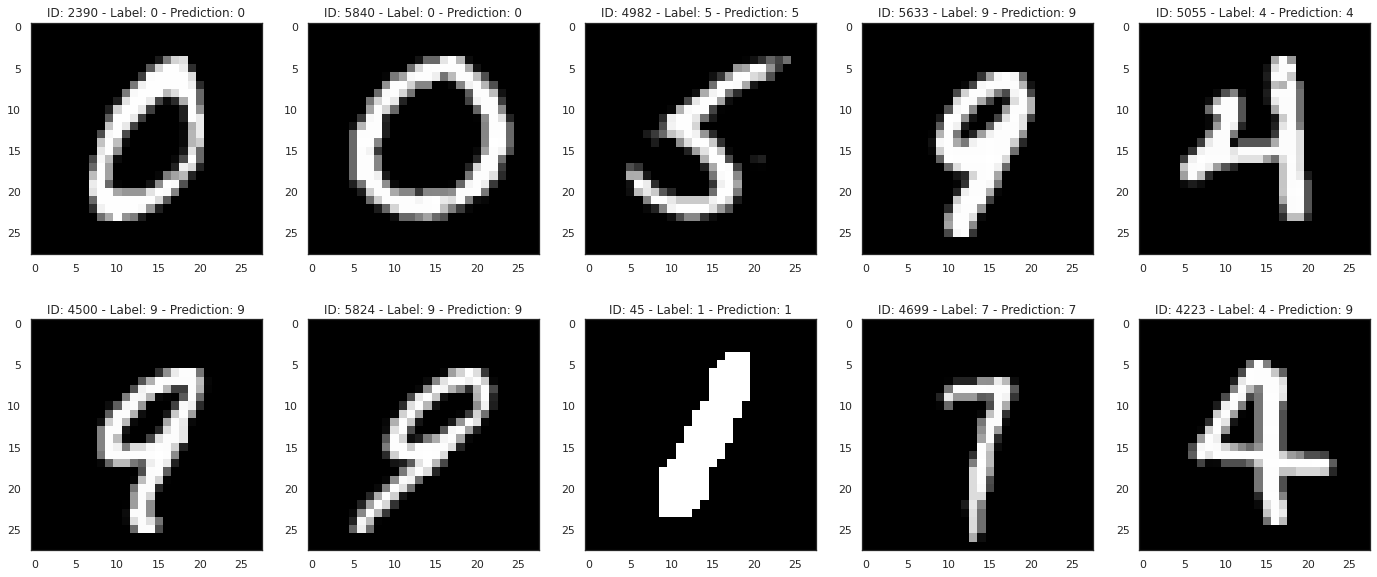

In [319]:
# metrics
eval_dict = LR.evaluate(test_data)
print('Accuracy:', eval_dict['accuracy'])
print('Loss:', eval_dict['loss'])

# plots
w = 5
h = 5
fig = plt.figure(figsize=(24, 10))
columns = 5
rows = 2

for i in range(1, columns*rows +1):
    idx = np.random.choice(len(test_data))
    image, label = test_data[idx]
    image = image[0, :, :]
    prediction = int(LR.predict(image.reshape(-1, 28*28)))

    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')
    plt.title('ID: {} - Label: {} - Prediction: {}'.format(idx, label, prediction))
plt.show()